# PCA K-Fold Reliability Analysis
This notebook analyzes the stability of PCA loadings across K-Fold splits using sign alignment. It helps assess the reliability of principal components for interpretability.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from preprocess.data_utils import make_test_and_stratified_folds, import_unit_removed_dataset
import os
os.chdir("..")

## Prepare Data and Folds
We use the reproducible make_test_and_stratified_folds function to get stratified folds for K-Fold analysis.

In [4]:
feature_names = ['passengers', 'nsmiles', 'rl_pax_str', 'tot_pax_str', 'large_ms', 'lf_ms']
X_test, y_test, folds, df_test, df_rest = make_test_and_stratified_folds(
    feature_cols=feature_names,
    import_fn=import_unit_removed_dataset,
    test_ratio=0.1,
    n_splits=10,
    shuffle=True,
    random_state=42
)

## Fit PCA on Each Fold and Align Signs
We fit PCA on each training fold, align the signs of the loadings, and collect them for analysis.

In [5]:
all_loadings = []
for fold in folds:
    X_train, y_train = fold['train']
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    pca = PCA(n_components=len(feature_names))
    pca.fit(X_train_scaled)
    loadings = pca.components_.copy()
    all_loadings.append(loadings)
all_loadings = np.array(all_loadings)  # shape: (n_folds, n_components, n_features)
# Sign alignment: align each fold's PC signs to the first fold
def align_signs(reference, target):
    aligned = target.copy()
    for i in range(reference.shape[0]):
        if np.dot(reference[i], target[i]) < 0:
            aligned[i] = -aligned[i]
    return aligned
ref_loadings = all_loadings[0]
for i in range(1, all_loadings.shape[0]):
    all_loadings[i] = align_signs(ref_loadings, all_loadings[i])

## Visualize PCA Loading Stability
We plot the loadings for the first 3 principal components across all folds to assess their stability.

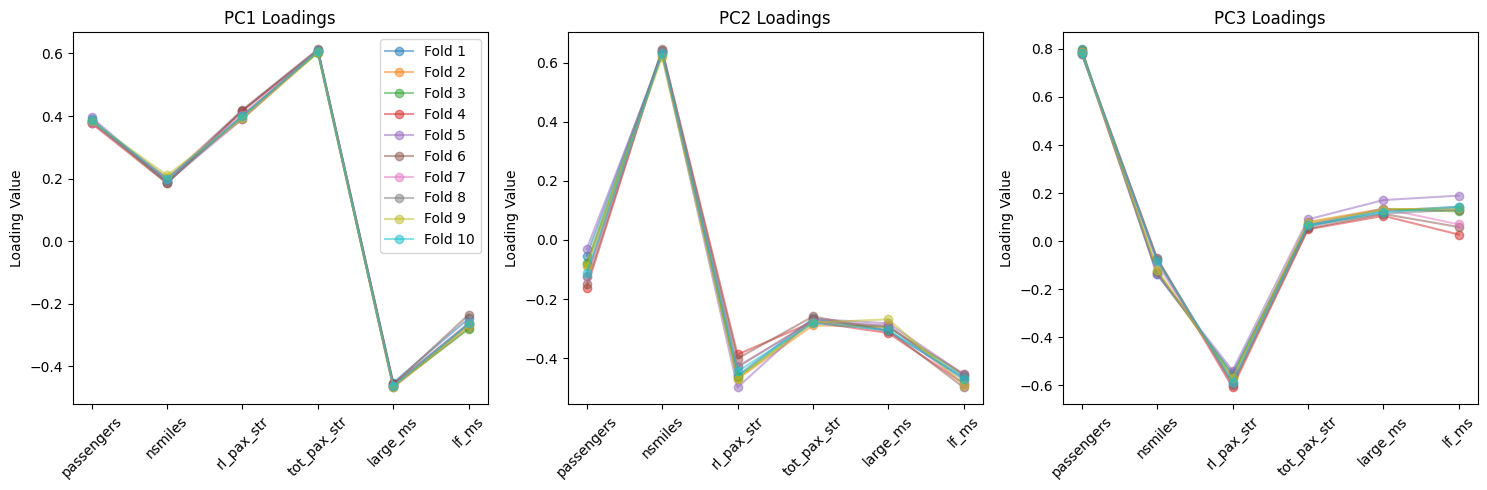

In [10]:
plt.figure(figsize=(15, 5))
for pc in range(3):  # Show first 3 PCs
    plt.subplot(1, 3, pc+1)
    for fold in range(all_loadings.shape[0]):
        plt.plot(all_loadings[fold, pc], marker='o', alpha=0.5, label=f'Fold {fold+1}' if pc==0 else '')
    plt.title(f'PC{pc+1} Loadings')
    plt.xticks(range(len(feature_names)), feature_names, rotation=45)
    plt.ylabel('Loading Value')
    if pc == 0:
        plt.legend()
plt.tight_layout()
plt.show()

## Mean and Standard Deviation of Loadings
We also print the mean and standard deviation of the loadings for each principal component across folds.

In [11]:
mean_loadings = all_loadings.mean(axis=0)
std_loadings = all_loadings.std(axis=0)
for pc in range(3):
    print(f'PC{pc+1} mean loadings: {mean_loadings[pc]}')
    print(f'PC{pc+1} std of loadings: {std_loadings[pc]}')

PC1 mean loadings: [ 0.38346332  0.19481885  0.40321558  0.60765518 -0.46207118 -0.26318464]
PC1 std of loadings: [0.00552051 0.00806148 0.01057418 0.00316863 0.00429507 0.01273477]
PC2 mean loadings: [-0.10060451  0.63422684 -0.445203   -0.27436226 -0.29527488 -0.47317019]
PC2 std of loadings: [0.03882589 0.00727176 0.0323111  0.0081619  0.01316276 0.01527085]
PC3 mean loadings: [ 0.78657068 -0.10533713 -0.57638663  0.06777663  0.12836436  0.11494867]
PC3 std of loadings: [0.00567266 0.02648843 0.0209752  0.01176113 0.01721462 0.0457862 ]
